# **Binary Classification with ResNet18 on CIFAR-10: Airplanes vs Cars**

---
# **Niloufar Abbasi | 401209996**
## **Deep Learning | December 2023**
---

Transfer learning has become a fundamental approach in deep learning, particularly for image classification tasks. By using pre-trained models like **AlexNet**, **ResNet50**, and others, which have been trained on large-scale datasets such as **ImageNet**, it is possible to transfer the learned representations to new tasks, significantly improving performance.

In many deep learning models, a loss function is employed to train the model. An important point to note is that this function is not exclusively limited to the last layer of the neural network; it can also be utilized in intermediate layers. Additionally, in many cases, we can enhance the training process by simultaneously using a weighted sum of multiple loss functions.

In this notebook, our goal is to train a classifier for two classes: **airplane** and **automobile**, using the **CIFAR-10** dataset. As you know, networks like ResNet and AlexNet include a fully connected layer, where the input is a feature vector, and the output corresponds to the number of classes. For example, in AlexNet, the output of the penultimate layer is a 4096-dimensional vector, which is mapped through a fully connected layer to a 1000-dimensional vector for the classification task. The early layers of these models capture essential low-level features such as edges, textures, and patterns that are generalizable across different image domains. These features are then passed to fully connected layers, where the network fine-tunes for the specific classification task.

### Benefits of Using Pre-Trained Models
Using pre-trained models, especially those trained on massive datasets like **ImageNet**, offers several advantages. These networks capture a wide range of visual features that can be directly applied to new tasks, reducing the amount of training data and computational resources required. The fine-tuning of the last few layers ensures that the model adapts to the specific target task without losing the benefits of the general features learned from the original dataset. This approach is particularly effective when dealing with smaller datasets or when aiming for high performance in specific domains.

Since our definition for extracting feature vectors may always have shortcomings and overlook certain aspects, when a large and diverse set of data is presented to networks like AlexNet and ResNet, the feature vector they produce may be superior to those defined by experts. In various tasks, it has been observed that these feature vectors can be meaningful even for problems that do not involve classification or where the categories differ from those in ImageNet, leading to good results.

---

### About this notebook:

This notebook explores deep learning techniques using PyTorch to classify images from the CIFAR-10 dataset, focusing specifically on binary classification between airplanes and cars (class 0 and class 1). Throughout the notebook, I employ transfer learning by fine-tuning the pre-trained ResNet18 model and using it for feature extraction and classification.

The pipeline includes:
1. Loading and preprocessing the CIFAR-10 dataset, filtering specific classes for binary classification.
2. Visualizing sample images to better understand the dataset.
3. Splitting the data into training, validation, and test sets for model evaluation.
4. Modifying the ResNet18 model for binary classification and training it using cross-entropy loss and the Adam optimizer.
5. Evaluating model performance by plotting training and validation accuracy and loss.
6. Implementing a second stage with a triplet loss-based feature extractor and classifier to enhance the model's ability to distinguish between the two classes.

(Note: This notebook uses Google Drive to save and load model checkpoints. To replicate the process, ensure that your Google Drive is mounted and update the paths as needed to match your own Drive directory.)

---

# **Libraries:**

In [ ]:
import matplotlib.pyplot      as plt
import numpy                  as np
import random
import time
import torch
import torch.nn               as nn
import torch.nn.functional    as F
import torch.optim            as optim
import torchvision
import torchvision.datasets   as datasets
import torchvision.models     as models
import torchvision.transforms as transforms
from   torch.autograd         import Variable
from   torch.utils.data       import Subset

I have integrated Google Drive with my notebook to facilitate the saving and reloading of models for each section of the code.

In [ ]:
# extract the contents of data.tar.gz
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This code below, sets up the device (GPU or CPU) for PyTorch computations and prints the type of device being used.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#----------------------------------------------------------------------
def print_device(x):
    if x.type == 'cpu':
        return 'CPU'
    else:
        return 'GPU'
#---------------------------------------------------------------------
print('Device: {}'.format(print_device(device)))
#---------------------------------------------------------------------
DEVICE = device

Device: GPU


**Load the CIFAR-10 dataset :**

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
trainset  = torchvision.datasets.CIFAR10(root='./data', train=True , download=True, transform=transform)
testset   = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Function to display random images
def show_random_images(dataset, num_images=5):
    classes = dataset.classes
    indices = random.sample(range(len(dataset)), num_images)

    # Create a subplot with the given number of columns
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 2 * num_rows))

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.numpy().transpose((1, 2, 0))
        mean = torch.tensor((0.4914, 0.4822, 0.4465))
        std = torch.tensor((0.2023, 0.1994, 0.2010))
        img = std * img + mean
        img = np.clip(img, 0, 1)

        if num_rows > 1:
            ax = axes[i // num_cols, i % num_cols]
        else:
            ax = axes[i % num_cols]

        ax.imshow(img)
        ax.set_title(classes[label])
        ax.axis('off')

    plt.show()

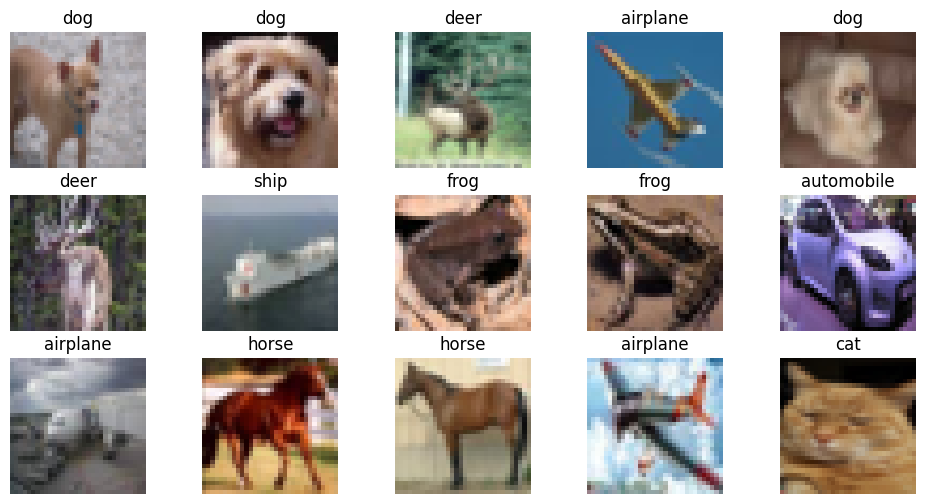

In [ ]:
# Display 15 random images from the training set
show_random_images(trainset, num_images=15)

**Filter out only airplane (class 0) and car (class 1) classes :**

In [ ]:
trainset.targets = torch.tensor(trainset.targets)
trainset.data    = trainset.data   [(trainset.targets == 0) | (trainset.targets == 1)]
trainset.targets = trainset.targets[(trainset.targets == 0) | (trainset.targets == 1)]
#=============================================================================================
testset.targets = torch.tensor(testset.targets)
testset.data    = testset.data   [(testset.targets == 0) | (testset.targets == 1)]
testset.targets = testset.targets[(testset.targets == 0) | (testset.targets == 1)]
#=============================================================================================
# Split the training set into training and validation sets
valid_size = 0.1  # 10% of the training set will be used for validation
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]
#=============================================================================================
# Create subsets for training and validation
train_subset = Subset(trainset, train_idx)
valid_subset = Subset(trainset, valid_idx)
#=============================================================================================
# Create data loaders for training, validation, and test sets
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True , num_workers=2)
validloader = torch.utils.data.DataLoader(valid_subset, batch_size=64, shuffle=False, num_workers=2)
testloader  = torch.utils.data.DataLoader(testset     , batch_size=64, shuffle=False, num_workers=2)

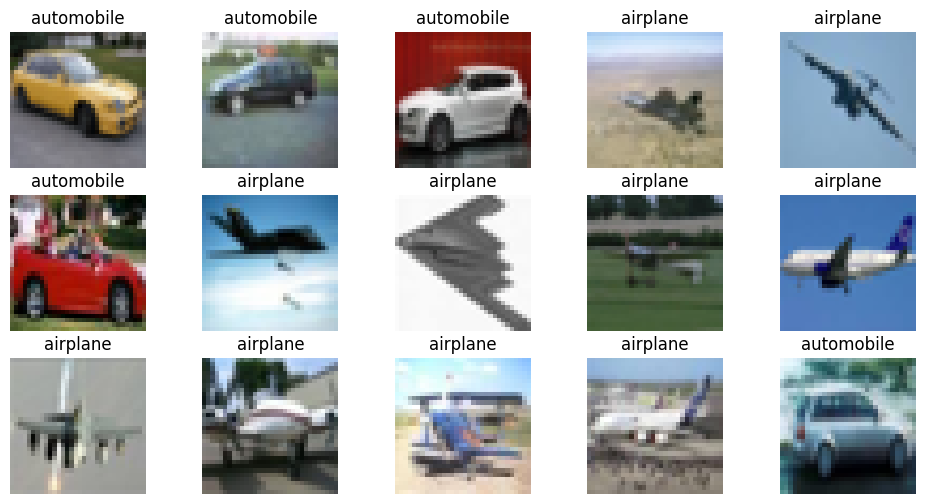

In [ ]:
# Display 15 random images from the training set
show_random_images(trainset, num_images=15)

# **Section 1**: Training and Evaluating the ResNet18 Model - Cross-Entropy loss

In this section, we load the pre-trained ResNet18 model from the `torchvision` library and adapt it for a binary classification task involving airplanes and automobiles using the CIFAR-10 dataset.

First, we freeze the weights of the pre-trained model to retain the learned features and modify the final fully connected layer to output two classes. We define the loss function as cross-entropy and use the Adam optimizer for training.

The model is trained over 12 epochs, during which we compute the training and validation accuracy and loss after each epoch. We log progress and performance metrics, allowing us to monitor the model's learning.

After training, we visualize the training and validation accuracy and loss using plots. Finally, we save the trained model to Google Drive and demonstrate how to reload it for evaluation. In the testing phase, we assess the model's performance on a separate test set, calculating the accuracy and loss to evaluate its effectiveness.


In [ ]:
# Load the pre-trained ResNet18 model
net1 = torchvision.models.resnet18(pretrained=True)

# Freeze the weights of the pre-trained model
for param in net1.parameters():
    param.requires_grad = False

# Modify the last layer for binary classification
net1.fc   = nn.Linear(net1.fc.in_features, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net1.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Lists to store training and validation accuracy values
train_acc_values  = []
valid_acc_values  = []
train_loss_values = []
valid_loss_values = []

# Train the network
for epoch in range(1, 13):  # Loop over the dataset for 12 epochs
    running_loss  = 0
    correct_train = 0
    total_train   = 0

    # Training loop
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i + 1) % 25 == 0:
            progress = 100. * i * trainloader.batch_size / len(trainset)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * trainloader.batch_size, len(train_subset), progress, loss.item()))

        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train       += labels.size(0)
        correct_train     += (predicted_train == labels).sum().item()

    train_accuracy = 100. * correct_train / total_train
    train_acc_values.append(train_accuracy)
    train_loss = running_loss / len(trainloader)
    train_loss_values.append(train_loss)

#-------------------------------------------------------------------------------

    # Validation loop
    correct_val = 0
    total_val   = 0
    val_loss    = 0

    with torch.no_grad():
        for data in validloader:
            images_val, labels_val = data
            outputs_val = net1(images_val)
            val_loss += criterion(outputs_val, labels_val)

            _, predicted_val = torch.max(outputs_val.data, 1)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum().item()

    val_loss /= len(validloader)
    val_accuracy = 100. * correct_val / total_val
    valid_acc_values.append(val_accuracy)
    valid_loss = val_loss.item()
    valid_loss_values.append(valid_loss)

    print('--------------------------------------------------------------------')
    print('Epoch: {} - Training Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(
        epoch, train_loss, train_accuracy, valid_loss, val_accuracy))
    print('--------------------------------------------------------------------')

print('Finished Training')

Train Epoch: 1 [1536/9000 (15%)]	Loss: 0.877996
Train Epoch: 1 [3136/9000 (31%)]	Loss: 0.788612
Train Epoch: 1 [4736/9000 (47%)]	Loss: 0.731970
Train Epoch: 1 [6336/9000 (63%)]	Loss: 0.649103
Train Epoch: 1 [7936/9000 (79%)]	Loss: 0.605886
--------------------------------------------------------------------
Epoch: 1 - Training Loss: 0.7225, Training Accuracy: 55.58%, Validation Loss: 0.5915, Validation Accuracy: 69.00%
--------------------------------------------------------------------
Train Epoch: 2 [1536/9000 (15%)]	Loss: 0.563097
Train Epoch: 2 [3136/9000 (31%)]	Loss: 0.574533
Train Epoch: 2 [4736/9000 (47%)]	Loss: 0.508126
Train Epoch: 2 [6336/9000 (63%)]	Loss: 0.585106
Train Epoch: 2 [7936/9000 (79%)]	Loss: 0.531815
--------------------------------------------------------------------
Epoch: 2 - Training Loss: 0.5485, Training Accuracy: 73.07%, Validation Loss: 0.4968, Validation Accuracy: 77.70%
--------------------------------------------------------------------
Train Epoch: 3 [

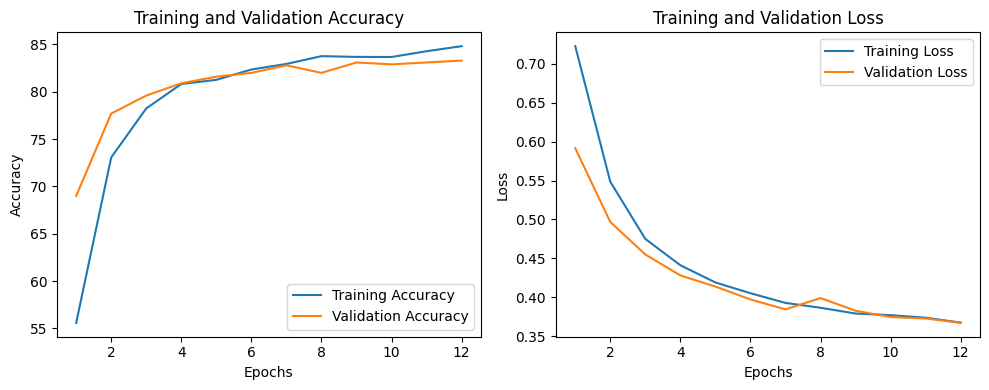

In [ ]:
# Plotting
plt.figure(figsize=(10, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(1, 13), train_acc_values, label='Training Accuracy')
plt.plot(range(1, 13), valid_acc_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, 13), train_loss_values, label='Training Loss')
plt.plot(range(1, 13), valid_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Model Save and Reload**

In [ ]:
# Save the model
torch.save(net1.state_dict(), '/content/drive/MyDrive/net1')
print('Model saved to Google Drive.')

# Reload the model
net1.load_state_dict(torch.load('/content/drive/MyDrive/net1'))

print('Model reloaded')

Model saved to Google Drive.
Model reloaded


In [ ]:
print("========================================")
print('Test Part')
print("========================================")

# Switch model to evaluation mode
net1.eval()

correct = 0
total = 0
test_loss = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net1(images)
        log_probs = F.log_softmax(outputs, dim=1)  # Apply log_softmax to get log probabilities
        test_loss += F.nll_loss(log_probs, labels, reduction='sum').item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= total
accuracy = 100. * correct / total

print('-------------------------------------------------------')
print('\nTest set: Accuracy: {}/{} ({:.2f}%)\n'.format(correct, total, accuracy))
print('Test Loss: {:.4f}'.format(test_loss))
print('-------------------------------------------------------')


Test Part
-------------------------------------------------------

Test set: Accuracy: 1681/2000 (84.05%)

Test Loss: 0.3731
-------------------------------------------------------


---


# **Section 2**: Training with Triplet Loss and Fine-Tuning the Classifier

In this section, we take advantage of **triplet loss** for enhanced feature extraction and fine-tune the ResNet18 model for binary classification.

### Triplet Loss Feature Extraction

We use **Triplet Loss** [(Triplet Loss Wiki)](https://en.wikipedia.org/wiki/Triplet_loss) to learn more discriminative feature embeddings. The triplet loss is calculated by minimizing the distance between anchor and positive samples while maximizing the distance between the anchor and negative samples. This helps the model learn better feature representations for distinguishing between the two classes (airplane and automobile).

- We define a custom `TripletLoss` class and modify the ResNet18 architecture to allow feature extraction while freezing the final fully connected layer.
- The model is trained for 50 epochs using triplet loss.
- We split each batch of training data into anchor, positive, and negative examples and calculate the loss accordingly.
- The training process is monitored by logging loss and validation accuracy after each epoch.

### Classifier Fine-Tuning

After feature extraction, we proceed with fine-tuning the classifier:

- The final fully connected layer is unfrozen, and the rest of the network is frozen.
- We train the model for 5 additional epochs, this time optimizing with **cross-entropy loss** to fine-tune the binary classifier.
- Validation accuracy and loss are calculated after each epoch to monitor the model's performance.

### Results and Plotting

We plot the training and validation accuracy and loss for both the feature extraction and classification stages. The results are displayed in four subplots:
1. **Feature Extractor Accuracy**
2. **Feature Extractor Loss**
3. **Classifier Accuracy**
4. **Classifier Loss**


Feature Extractor Part
Epoch 1/30, Loss: 0.4206,  Validation Accuracy: 0.9060
-------------------------------------------------------------
Epoch 2/30, Loss: 0.3054,  Validation Accuracy: 0.9360
-------------------------------------------------------------
Epoch 3/30, Loss: 0.1535,  Validation Accuracy: 0.9590
-------------------------------------------------------------
Epoch 4/30, Loss: 0.2075,  Validation Accuracy: 0.9600
-------------------------------------------------------------
Epoch 5/30, Loss: 0.0655,  Validation Accuracy: 0.9470
-------------------------------------------------------------
Epoch 6/30, Loss: 0.0974,  Validation Accuracy: 0.9680
-------------------------------------------------------------
Epoch 7/30, Loss: 0.0325,  Validation Accuracy: 0.9570
-------------------------------------------------------------
Epoch 8/30, Loss: 0.0703,  Validation Accuracy: 0.9690
-------------------------------------------------------------
Epoch 9/30, Loss: 0.0758,  Validation Acc

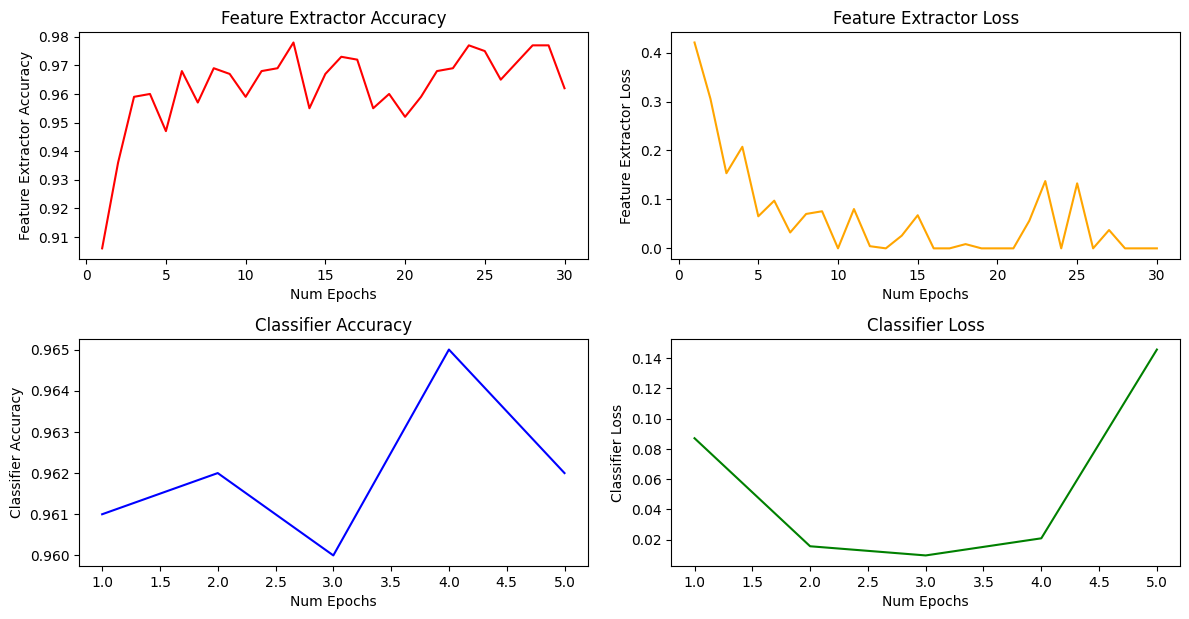

In [ ]:
net2 = models.resnet18(pretrained=True)
net2.fc = nn.Linear(net2.fc.in_features,2)

####################################
for param in net2.parameters():    #
    param.requires_grad=True       #
for param in net2.fc.parameters(): #
    param.requires_grad=False      #
####################################

#-------------------------------------------------------------------------------
# Define triplet loss function
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = nn.functional.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()
#-------------------------------------------------------------------------------

triplet_loss = TripletLoss()

net2.to(device)
triplet_loss.to(device)
optimizer = optim.Adam(net2.parameters(), lr=0.001)

#-------------------------------------------------------------------------------

print("========================================")
print('Feature Extractor Part')
print("========================================")

'''
I think due to the large number of parameters in this section, more epochs are needed.
Therefore, based on the plots, I believe 75 epochs would be appropriate.
'''

# Train the model
F_E_num_epochs = 50
F_E_accuracies = np.zeros(F_E_num_epochs)
F_E_losses     = np.zeros(F_E_num_epochs)

for epoch in range(F_E_num_epochs):

#===============================================================================
    # Training loop
    for data in trainloader:
        images, labels = data
        # Split images into anchor, positive, and negative examples
        anchor_im   = []
        positive_im = []
        negative_im = []
        for i in range(images.size(0)):
            anchor_im.append(images[i])
            positive_label = labels[i]
            while True:
                pos_idx = torch.randint(0, images.size(0), (1,))
                if labels[pos_idx] == positive_label:
                    break
            positive_im.append(images[pos_idx])
            while True:
                neg_idx = torch.randint(0, images.size(0), (1,))
                if labels[neg_idx] != positive_label:
                    break
            negative_im.append(images[neg_idx])

        anchor_im   = torch.stack(anchor_im).to(device)
        positive_im = torch.stack(positive_im).to(device)
        negative_im = torch.stack(negative_im).to(device)

        # Forward pass and calculate triplet loss
        anchor_embed   = net2(anchor_im)
        positive_embed = net2(np.squeeze(positive_im))
        negative_embed = net2(np.squeeze(negative_im))
        loss = triplet_loss(anchor_embed, positive_embed, negative_embed)

        # Backward pass and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        F_E_losses[epoch] = loss

#===============================================================================

    # Validation loop
    with torch.no_grad():
        correct = 0
        total = 0
        for data in validloader:
            images, labels = data
            images=images.to(device)
            labels=labels.to(device)
            embed = net2(images)
            outputs = nn.functional.softmax(embed, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = correct / total
        F_E_accuracies[epoch] = accuracy

    print(f"Epoch {epoch+1}/{F_E_num_epochs}, Loss: {loss.item():.4f},  Validation Accuracy: {accuracy:.4f}")
    print('-------------------------------------------------------------')

#-------------------------------------------------------------------------------

print("========================================")
print('Classifier Part')
print("========================================")

####################################
for param in net2.parameters():    #
    param.requires_grad=False      #
for param in net2.fc.parameters(): #
    param.requires_grad=True       #
####################################

C_num_epochs = 5

Classifier_accuracies = np.zeros(C_num_epochs)
Classifier_losses     = np.zeros(C_num_epochs)

# Define loss function and optimizer
optimizer=optim.Adam(net2.fc.parameters(),lr=0.001)

# Train the model

for epoch in range(C_num_epochs):

#==============================================================================
    # Training loop
    for data in trainloader:
        images, labels = data
        images=images.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        outputs=net2(images)
        loss=nn.CrossEntropyLoss()(outputs,labels)
        loss.backward()
        Classifier_losses[epoch] = loss
        optimizer.step()

#===============================================================================

    # Validation loop
    with torch.no_grad():
        all_labels=0
        acc=0
        for images,labels in validloader:
            images=images.to(device)
            labels=labels.to(device)
            outputs=net2(images)
            _,predicted_labels=torch.max(outputs.data,1)
            all_labels=all_labels+labels.size(0)
            acc=acc+torch.sum((predicted_labels==labels))
        Classifier_accuracies[epoch] = (acc/all_labels)


    print(f"Epoch {epoch+1}/{C_num_epochs}, Loss: {Classifier_losses[epoch].item():.4f}, Accuracy: { Classifier_accuracies[epoch]:.4f}")
    print('-------------------------------------------------------------')


#-------------------------------------------------------------------------------
plt.figure(figsize=(12, 12))
#-------------------------------------------------------------------------------

epochs=np.linspace(1,F_E_num_epochs,F_E_num_epochs)

plt.subplot(4, 2, 1)
plt.plot(epochs, F_E_accuracies, color = 'red')
plt.title("Feature Extractor Accuracy")
plt.xlabel("Num Epochs")
plt.ylabel("Feature Extractor Accuracy")

plt.subplot(4, 2, 2)
plt.plot(epochs, F_E_losses, color = 'orange')
plt.title("Feature Extractor Loss")
plt.xlabel("Num Epochs")
plt.ylabel("Feature Extractor Loss")

#-------------------------------------------------------------------------------

epochs=np.linspace(1,C_num_epochs,C_num_epochs)

plt.subplot(4, 2, 3)
plt.plot(epochs, Classifier_accuracies, color = 'blue')
plt.title("Classifier Accuracy")
plt.xlabel("Num Epochs")
plt.ylabel("Classifier Accuracy")

plt.subplot(4, 2, 4)
plt.plot(epochs, Classifier_losses , color = 'green')
plt.title("Classifier Loss")
plt.xlabel("Num Epochs")
plt.ylabel("Classifier Loss")

#-------------------------------------------------------------------------------

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

The vertical scales of the plots vary, so attention should be paid when interpreting the results.

### Model Saving and Reloading

The trained model is saved to Google Drive for future use. We demonstrate how to reload the model, making it ready for evaluation on the test set.


In [ ]:
# Save the model
torch.save(net2.state_dict(), '/content/drive/MyDrive/net2')
print('Model saved to Google Drive.')

# Reload the model
net2.load_state_dict(torch.load('/content/drive/MyDrive/net2'))

print('Model reloaded')

Model saved to Google Drive.
Model reloaded


### Test Results

Finally, the model is evaluated on the test set to assess its final accuracy and loss. The results are printed, showing the model's performance



In [ ]:
print("========================================")
print('Test Part')
print("========================================")

# Switch model to evaluation mode
net2.eval()

test_loss = 0
total = 0
correct = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = net2(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        test_loss += loss.item() * labels.size(0)
        total += labels.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

average_test_loss = test_loss / total
test_accuracy = correct / total

print(f"Test Loss: {average_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Part
Test Loss: 0.1248
Test Accuracy: 0.9610


---

# **Section 3**: Fine-tuning ResNet18 with Triplet Loss and Cross-Entropy Loss

In this section, we fine-tune a pre-trained ResNet18 model for binary classification. The final fully connected layer of the model is replaced to adapt it for distinguishing between two classes. The goal is to utilize both triplet loss for feature extraction and cross-entropy loss for classification, which together improve the overall model performance.

### Model Architecture and Modifications
We initialize the ResNet18 model, which is pre-trained on the ImageNet dataset. The original fully connected layer is adjusted to output predictions for two classes, and all parameters of the model are set to be trainable. This allows the model to learn from our specific dataset while retaining the general features learned during pre-training.

### Custom Triplet Loss Function
To enhance feature separation between classes, we define a custom triplet loss function. This loss computes the Euclidean distances between anchor, positive, and negative samples, ensuring that the positive sample is closer to the anchor compared to the negative sample. Specifically, the loss is formulated as:

$$
L_{\text{triplet}} = \max(0, d_{\text{anchor, positive}} - d_{\text{anchor, negative}} + \text{margin})
$$

where \( d \) represents the Euclidean distance, and **margin** is a small positive value that encourages better separation.

### Training Process
The training loop consists of 10 epochs. In each epoch, the model learns through both the triplet and cross-entropy loss functions. For each iteration, we compute the triplet loss for feature extraction and the cross-entropy loss for classification. The total loss is then expressed as:

$$
L_{\text{total}} = L_{\text{triplet}} + L_{\text{cross-entropy}}
$$

This combined loss is backpropagated through the network to update the model weights effectively, allowing the model to improve its performance iteratively.

### Validation
After each training epoch, we evaluate the model on the validation set to measure its accuracy. The accuracy for each epoch is recorded and plotted at the end of the training phase. This validation process ensures the model is generalizing well to unseen data and helps in monitoring potential overfitting.

### Results and Visualization
At the end of the training, we generate two plots: one for accuracy across epochs and another for the loss values over time. These visualizations provide insights into the training dynamics, revealing how well the model is learning and adjusting.


Epoch 1/10, Loss: 1.2072, Accuracy: 0.9490
-------------------------------------
Epoch 2/10, Loss: 1.0621, Accuracy: 0.9620
-------------------------------------
Epoch 3/10, Loss: 1.0491, Accuracy: 0.9600
-------------------------------------
Epoch 4/10, Loss: 1.0037, Accuracy: 0.9560
-------------------------------------
Epoch 5/10, Loss: 1.0009, Accuracy: 0.9720
-------------------------------------
Epoch 6/10, Loss: 1.0083, Accuracy: 0.9530
-------------------------------------
Epoch 7/10, Loss: 1.0766, Accuracy: 0.9670
-------------------------------------
Epoch 8/10, Loss: 1.0107, Accuracy: 0.9630
-------------------------------------
Epoch 9/10, Loss: 1.0007, Accuracy: 0.9630
-------------------------------------
Epoch 10/10, Loss: 1.0004, Accuracy: 0.9620
-------------------------------------


Text(0, 0.5, 'Accuracy')

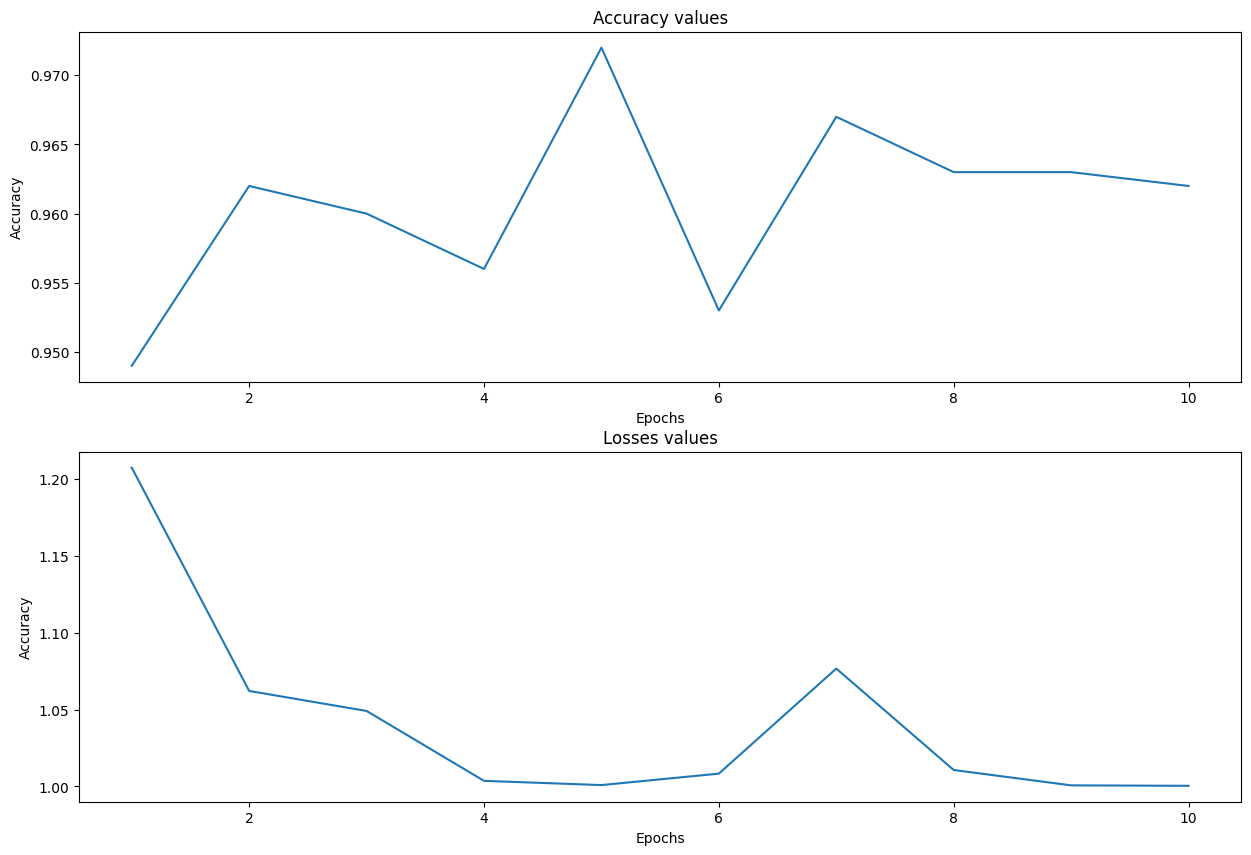

In [ ]:
#-------------------------------------------
net3 = models.resnet18(pretrained=True)
net3.fc = nn.Linear(net3.fc.in_features,2)
#-------------------------------------------

#####################################
for param in net3.parameters():    #
    param.requires_grad=True        #
for param in net3.fc.parameters(): #
    param.requires_grad=True        #
#####################################

# Define triplet loss function
class Tri_CE(nn.Module):
    def __init__(self, margin=1.0):
        super(Tri_CE, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = nn.functional.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

triplet_and_cross_entropy_loss = Tri_CE()

#-------------------------------------------

net3.to(device)
triplet_and_cross_entropy_loss.to(device)
optimizer = optim.Adam(net3.parameters(), lr=0.0001)

# Train the model
num_epochs = 10
accuracies = np.zeros(num_epochs)
losses = np.zeros(num_epochs)
for epoch in range(num_epochs):
    # Training loop
    for data in trainloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass and calculate triplet loss
        anchor_embed   = net3(images)
        positive_embed = net3(images)
        negative_embed = net3(images)
        firstLoss = triplet_and_cross_entropy_loss(anchor_embed, positive_embed, negative_embed)
        firstLoss.backward(retain_graph=True)
        outputs = net3(images)
        SecondLoss = nn.CrossEntropyLoss()(outputs, labels)
        SecondLoss.backward()
        loss = firstLoss + SecondLoss
        optimizer.step()
        losses[epoch] = loss.item()

#===============================================================================

    # Validation loop
    with torch.no_grad():
        correct = 0
        total = 0
        for data in validloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            embed = net3(images)
            outputs = nn.functional.softmax(embed, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        accuracies[epoch] = accuracy

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
    print("-------------------------------------")
#-------------------------------------------------------------------------------

epochs=np.linspace(1,num_epochs,num_epochs)

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(epochs,accuracies)
plt.title("Accuracy values")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,1,2)
plt.plot(epochs,losses)
plt.title("Losses values")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")


### Model Saving and Reloading
The trained model is saved to Google Drive for future use and can be reloaded later for inference or further fine-tuning. This step is crucial for preserving the progress made during training.


In [ ]:
# Save the model
torch.save(net3.state_dict(), '/content/drive/MyDrive/net3')
print('Model saved to Google Drive.')

# Reload the model
net3.load_state_dict(torch.load('/content/drive/MyDrive/net3'))

print('Model reloaded')

Model saved to Google Drive.
Model reloaded



### Test Phase
After completing training, we switch the model to evaluation mode and test it on the test dataset. The final test accuracy is computed and reported. As observed in this section, the model achieves its highest accuracy compared to the previous sections, indicating significantly improved performance due to the effective integration of triplet loss and cross-entropy loss.

In [ ]:
print("========================================")
print('Test Part')
print("========================================")

# Switch model to evaluation mode
net1.eval()

# Test loop
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = net3(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Part
Test Accuracy: 0.9680
